In [ ]:
from typing import Optional
from pathlib import Path

def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()
PROJECT_ROOT

In [ ]:
import mlflow
# Provide uri and connect to your tracking server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

In [17]:
model_name = "AU_Logistic_Regression"

In [31]:
import mlflow.sklearn
stage = "production"
model = mlflow.sklearn.load_model(
    model_uri=f"models:/{model_name}/{stage}")

model

LogisticRegression(fit_intercept=False)

In [49]:
import pandas as pd

def pre_processing(df):
    df['prev'] = df['production'].shift(1)
    df['sma2'] = df['prev'].rolling(window=2).mean()
    df['sma5'] = df['prev'].rolling(window=5).mean()
    df['sma10'] = df['prev'].rolling(window=10).mean()
    df['sma20'] = df['prev'].rolling(window=20).mean()
    df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
    df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

    def difference(prev_price, moving_average):
        return (prev_price - moving_average) / prev_price

    for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
        df['{}_diff'.format(col)] = difference(df['prev'], df[col])
    df = df.fillna(-99)    
    df = df.drop(['Date'], axis=1)
    return df
# df.head()

In [50]:
# prediction = model.predict(df)


# X_val = df.values
instance = [[619.8,618.45,-99.0,-99.0,-99.0,-99.0,-99.0,0.002178,-99.0,-99.0,-99.0,-99.0,-99.0]]
pred = model.predict_proba(instance)[:, 1]

In [ ]:
pred

In [55]:
# Python
from prophet.serialize import model_to_json, model_from_json
with open(r'C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\model\prophet\US.json', 'r') as fin:
    model2 = model_from_json(fin.read())  # Load model

C:\Users\Harsha\anaconda3\envs\fp2\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [56]:
future_dates = model2.make_future_dataframe(periods=12, freq='MS')

In [59]:
forecast = model2.predict(future_dates)
# forecast["y"] = df["y"]
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2002-01-01,5768.794211,4799.097547,6814.728499
1,2002-02-01,5698.887896,4754.520710,6647.965790
2,2002-03-01,5786.400000,4745.890613,6803.535455
3,2002-04-01,5757.721270,4773.412684,6698.103975
4,2002-05-01,5726.520939,4756.278664,6751.075360


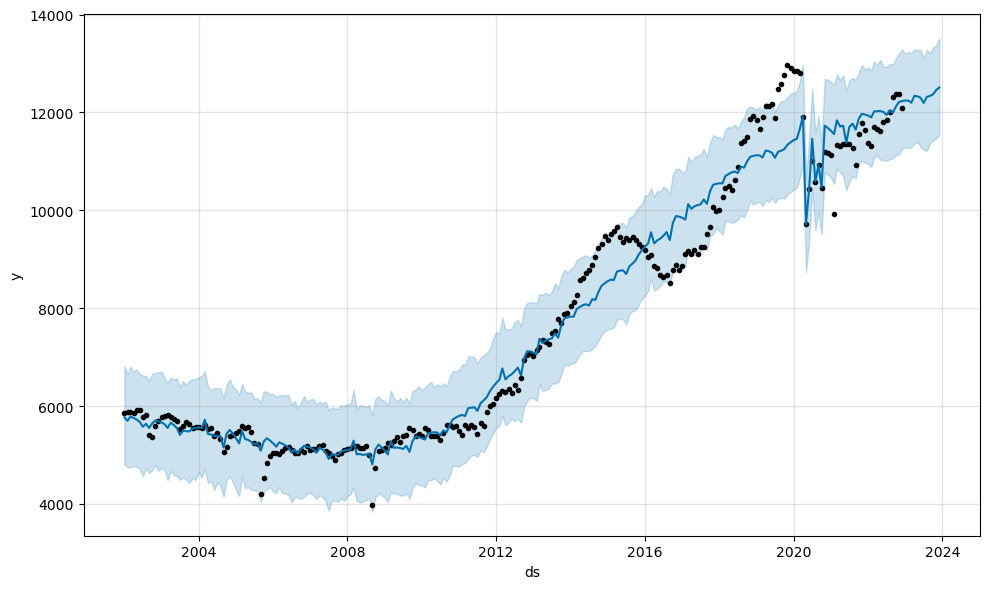

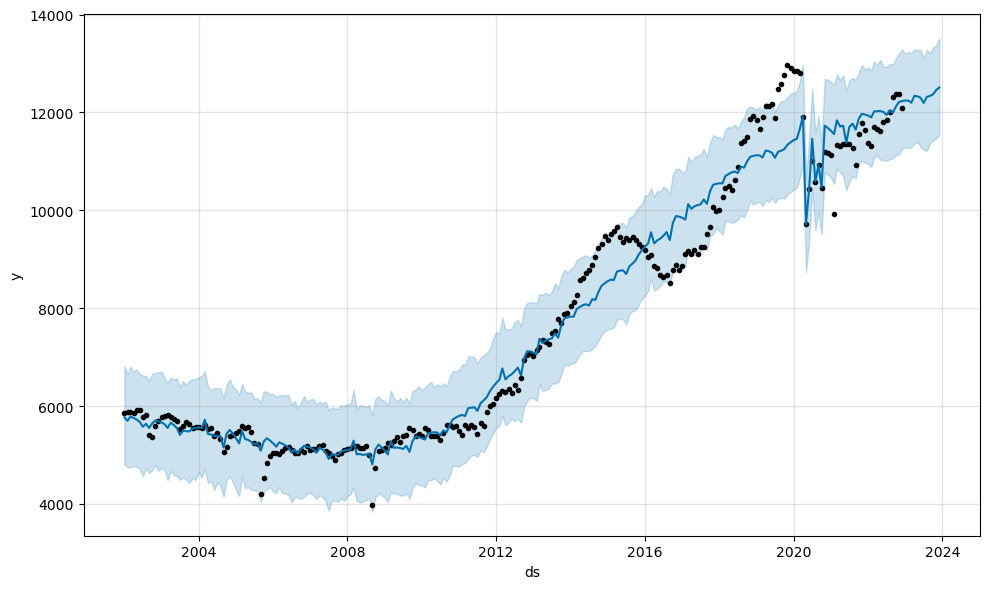

In [60]:
model2.plot(forecast, uncertainty=True)